# <span style="color:green"><center>Diplomado en Big Data</center></span>

# <span style="color:red"><center> Arrays: Grandes arreglos n-dimensionales paralelizados<center></span>

<img src="../images/dask_horizontal.svg" align="right" width="30%">


##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Contenido</span>

* [Introducción](#Introducción)
* [Creación de datos](#Creación-de-datos)
* [Configuración](#Configuración)
* [Algoritmos bloqueados o por bloques](#Algoritmos-bloqueados-o-por-bloques)

## <span style="color:blue">Fuente</span>

Esta es una traducción libre del tutorial disponible en [dask-tutorial](https://github.com/dask/dask-tutorial).

## <span style="color:blue">Introducción</span>

<img src="../images/array.png" width="25%" align="right">
Dask proporcionan  arreglos n-dimensional, para computación en paralelo, los cuales pueden ser más grande que la memoria, utilizando algoritmos bloqueados. En pocas palabras: es  Numpy distribuido.

* **Paralelo**: utiliza todos los núcleos de su computadora
* **Más grande que la memoria**: le permite trabajar en conjuntos de datos que son más grandes que su memoria disponible al dividir su matriz en muchas partes pequeñas, operar en esas partes en un orden que minimiza la huella de memoria de su cálculo y Transmitir datos de forma efectiva desde el disco.
* **Algoritmos bloqueados**: Realice grandes cálculos ejecutando muchos cálculos más pequeños

En este cuaderno, desarrollaremos los conceptos implementando algunos algoritmos bloqueados desde cero.
Luego usaremos Dask Array para analizar grandes conjuntos de datos, en paralelo, usando una API familiar similar a NumPy.

### Documentación relacionada

* [Array documentation](https://docs.dask.org/en/latest/array.html)
* [Array screencast](https://youtu.be/9h_61hXCDuI)
* [Array API](https://docs.dask.org/en/latest/array-api.html)
* [Array examples](https://examples.dask.org/array.html)

## <span style="color:blue">Creación de datos</span>

In [ ]:
# %run prep.py -d random

## <span style="color:blue">Configuración</span>

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

/home/alvaro/anaconda3/envs/dask-tutorial/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41779 instead
  warnings.warn(


## <span style="color:blue">Algoritmos bloqueados o por bloques</span>

Un *algoritmo  bloqueado* o por bloques se ejecuta sobre un gran conjunto de datos dividiéndolo en muchos bloques pequeños.

Por ejemplo, considere tomar la suma de mil millones de números. En su lugar, podríamos dividir la matriz en 1.000 fragmentos, cada uno de un tamaño de 1.000.000, tomar la suma de cada fragmento y luego tomar la suma de las sumas intermedias.

Logramos el resultado deseado (una suma en mil millones de números) realizando muchos resultados más pequeños (mil sumas en un millón de números cada una, seguidas de otra suma de mil números).

Hacemos exactamente esto con Python y NumPy en el siguiente ejemplo:

In [ ]:
# Load data with h5py
# this creates a pointer to the data, but does not actually load
import h5py
import os
f = h5py.File(os.path.join('../data', 'random.hdf5'), mode='r')
dset = f['/x']


Para inspeccionar un archivo de tipo hdf5, tenga en cuenta que los datos son almacenados como diccionarios. Entonces puede hacer una primera inspección de las claves del archivo apuntado por *f* con `f.keys()`. En el ejemplo tenemos que

- *f* es un puntero a un archivo de tipo hdf5 
- *dset* es un puntero al dataset con clave 'x' en el archivo apuntado por *f*.

Veamos:

In [6]:
print(list(f.keys()))
print(type(f))
print(type(dset))

['x']
<class 'h5py._hl.files.File'>
<class 'h5py._hl.dataset.Dataset'>


### Calcule la suma usando una algoritmo bloqueado

Antes de usar dask, consideremos el concepto de algoritmos bloqueados. Podemos calcular la suma de una gran cantidad de elementos cargándolos fragmento por fragmento y manteniendo un total acumulado.

Aquí calculamos la suma de esta gran matriz en el disco por

1. Calcular la suma de cada 1.000.000 de fragmentos de la matriz.
2. Calcular la suma de las 1000 sumas intermedias

Tenga en cuenta que este es un proceso secuencial en el kernel del portátil, tanto la carga como la suma.

In [5]:
# Compute sum of large array, one million numbers at a time
sums = []
for i in range(0, 1_000_000_000, 1_000_000):
    chunk = dset[i: i + 1_000_000]  # pull out numpy array
    sums.append(chunk.sum())

total = sum(sums)
print(total)

1000044057.375


### Ejercicio: Calcule la media usando un algoritmo bloqueado

Ahora que hemos visto el ejemplo simple anterior, intente resolver un problema un poco más complicado. Calcule la media de la matriz, asumiendo por un momento que no sabemos cuántos elementos hay en los datos. Puede hacer esto cambiando el código anterior con las siguientes alteraciones:

1. Calcule la suma de cada bloque
2. Calcule la longitud de cada bloque
3. Calcule la suma de las 1000 sumas intermedias y la suma de las 1000 longitudes intermedias y divida una por la otra.

Este enfoque es excesivo para nuestro caso, pero se generaliza muy bien si no conocemos el tamaño de la matriz o los bloques individuales de antemano.

In [ ]:
# Compute the mean of the array

In [11]:
sums = []
lengths = []
for i in range(0, 1_000_000_000, 1_000_000):
    chunk = dset[i: i + 1_000_000]  # pull out numpy array
    sums.append(chunk.sum())
    lengths.append(len(chunk))

total = sum(sums)
length = sum(lengths)
print(total / length)

1.000044057375


`dask.array` contiene estos algoritmos
--------------------------------------------

Dask.array es una biblioteca similar a NumPy que hace este tipo de trucos para operar en grandes conjuntos de datos que no caben en la memoria. Se extiende más allá de los problemas lineales discutidos anteriormente a algoritmos N-dimensionales completos y un subconjunto decente de la interfaz NumPy.

### Creación de un objeto `dask.array` 

Se puede crear un arreglo(`Array`) `dask.array` con la función `da.from_array`.  Esta función acepta:

1.  `data`: Cualquier objeto que soporte  NumPy slicing, como `dset`
2.  `chunks`: Un tamaño de fragmento para decirnos cómo bloquear nuestra matriz, como `(1_000_000,)`

In [6]:
import dask.array as da
x = da.from_array(dset, chunks=(1_000_000,))
x

,Array,Chunk
Bytes,4.00 GB,4.00 MB
Shape,"(1000000000,)","(1000000,)"
Count,1001 Tasks,1000 Chunks
Type,float32,numpy.ndarray


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


### Manipulación de objetos  `dask.array` como si fueran arreglos NumPy.

Ahora que tenemos un `Array`, realizamos cálculos estándar de estilo numérico como aritmética, matemáticas, rebanado, reducciones, etc.

La interfaz es familiar, pero el trabajo real es diferente. `dask_array.sum()` no hace lo mismo que `numpy_array.sum()`.

### ¿Cuál es la diferencia?

`dask_array.sum()` construye una expresión del cálculo. Aún no hace el cálculo. `numpy_array.sum()` calcula la suma inmediatamente.

*¿Por qué la diferencia?*

Las matrices de Dask se dividen en trozos. Cada fragmento debe tener cálculos ejecutados en ese fragmento explícitamente. 

Si la respuesta deseada proviene de una pequeña porción de todo el conjunto de datos, ejecutar el cálculo sobre todos los datos sería un desperdicio de CPU y memoria.

In [7]:
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

### Calcula result

Los objetos Dask.array se evalúan de forma perezosa. Operaciones como `.sum` crean un gráfico de tareas bloqueadas para ejecutar.

Solicitamos el resultado final con una llamada a `.compute()`. Esto desencadena el cálculo real.

In [8]:
result.compute()

1000044000.0

### Ejercicio:  calcule la media

Y la varianza, std, etc. Esto debería ser un pequeño cambio en el ejemplo anterior.

Mire qué otras operaciones puede hacer con la finalización de tabulación del cuaderno de Jupyter.

In [9]:

media = x.mean()
var = x.var()
min_val = x.min()


In [10]:
print(media.compute())
print(var.compute())
print(min_val.compute())

1.000044
1.0000926
2.6702671e-09


¿Coincide esto con el resultado de antes?

Rendimiento y paralelismo
-------------------------------

<img src = "../images/fail-case.gif" width = "40%" align = "right">

En nuestros primeros ejemplos usamos bucles `for` para recorrer la matriz un bloque a la vez. Para operaciones simples como "suma", esto es óptimo. Sin embargo, para operaciones complejas, es posible que deseemos recorrer la matriz de manera diferente. En particular, es posible que deseemos lo siguiente:

1. Utilice varios núcleos en paralelo
2. Encadenar  operaciones en un solo bloque antes de pasar al siguiente

`Dask.array` traduce sus operaciones de matriz en un gráfico de tareas interrelacionadas con dependencias de datos entre ellas. Dask luego ejecuta este gráfico en paralelo con múltiples subprocesos. Discutiremos más sobre esto en la siguiente sección.

### Ejemplo

1. Construya una matriz de 20000x20000 de valores aleatorios normalmente distribuidos divididos en trozos de tamaño 1000x1000
2. Calcula la media a lo largo de un eje.
3. Toma cada cien elementos

In [14]:
import numpy as np
import dask.array as da

x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array 
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::100]                            # Perform NumPy-style operations

In [13]:
x.nbytes / 1e9  # Gigabytes of the input processed lazily

3.2

In [16]:
y.shape

(200,)

In [14]:
%%time
y.compute()     # Time to compute the result

CPU times: user 2.44 s, sys: 286 ms, total: 2.72 s
Wall time: 8.69 s


array([ 9.9989215 ,  9.99968716,  9.99927273, 10.0007045 , 10.00024887,
       10.00028405, 10.00030822, 10.00079583,  9.99895323, 10.00015781,
       10.00013859, 10.00085897, 10.00034425,  9.99964805, 10.00061679,
        9.99887458, 10.00017852, 10.00170883, 10.00106123,  9.99963821,
       10.00073969, 10.00049258,  9.99871877, 10.00155872,  9.99970209,
        9.99930109, 10.00031548, 10.00050111,  9.99927475,  9.99901415,
        9.99987058,  9.99974991, 10.0008343 , 10.00098098,  9.99977711,
        9.99839027,  9.99982019,  9.99911637, 10.00055103, 10.00090667,
        9.9998439 , 10.00024743,  9.99950129,  9.99953935,  9.99929548,
       10.00002583,  9.99925749, 10.00094349, 10.00012236, 10.00050856,
       10.00009789,  9.99958058, 10.00036899, 10.00066764, 10.00042133,
        9.99849623, 10.00020753,  9.99980957, 10.00044673,  9.99981941,
       10.001037  ,  9.99992539,  9.99967897, 10.00082097, 10.00033864,
        9.99964053, 10.00000462, 10.00016211,  9.99994469,  9.99

Comparación de rendimiento
---------------------------

El siguiente experimento se realizó en una computadora portátil personal pesada. Su desempeño puede variar. Si intenta la versión NumPy, asegúrese de tener más de 4 GB de memoria principal.

### NumPy: 19s, Necesita gigabytes de memoria

```python
import numpy as np

%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y

CPU times: user 19.6 s, sys: 160 ms, total: 19.8 s
Wall time: 19.7 s
```

### Dask Array: 4s, Necesita megabytes de memoria

```python
import dask.array as da

%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 29.4 s, sys: 1.07 s, total: 30.5 s
Wall time: 4.01 s
```

### Discusión

Observe que el cálculo de la matriz Dask se ejecutó en 4 segundos, pero utilizó 29,4 segundos de tiempo de CPU del usuario. El cálculo NumPy se ejecutó en 19,7 segundos y utilizó 19,6 segundos de tiempo de CPU del usuario.

Dask terminó más rápido, pero usó más tiempo total de CPU porque Dask pudo paralelizar de manera transparente el cálculo debido al tamaño del fragmento.

### Preguntas

* ¿Qué sucede si dask chunks = (20000,20000)?
    * ¿Se ejecutará el cálculo en 4 segundos?
    * ¿Cuánta memoria se utilizará?
* ¿Qué sucede si el dask chunks = (25,25)?
    * ¿Qué pasa con la CPU y la memoria?

### Ejercicio. Datos metereológicos

Hay 2GB de datos meteorológicos algo artificiales en archivos HDF5 en `data/weather-big/*. Hdf5`. Usaremos la biblioteca `h5py` para interactuar con estos datos y `dask.array` para calcularlos.

Nuestro objetivo es visualizar la temperatura promedio en la superficie de la Tierra para este mes. Esto requerirá una media de todos estos datos. Haremos esto en los siguientes pasos

1. Cree objetos `h5py.Dataset` para cada uno de los días de datos en el disco (`dsets`)
2. Envuelva estos con llamadas `da.from_array`
3. Apile estos conjuntos de datos a lo largo del tiempo con una llamada a `da.stack`
4. Calcule la media a lo largo del eje de tiempo recién apilado con el método `.mean()`
5. Visualice el resultado con `matplotlib.pyplot.imshow`

In [ ]:
# %run prep.py -d weather

Vaya a la terminal y en la carpeta dask-tutoria ejecute el siguiente comando para crear lo datos

In [11]:
import h5py
from glob import glob
import os

filenames = sorted(glob(os.path.join('../data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]

print(h5py.File(filenames[0], mode='r').keys())
print(dsets[0])

<KeysViewHDF5 ['t2m']>
<HDF5 dataset "t2m": shape (5760, 11520), type "<f8">


In [18]:
dsets[0][:5, :5]  # Slicing into h5py.Dataset object gives a numpy array

array([[22.53240967, 23.89801025, 25.26361084, 26.62921143, 27.99481201],
       [23.89801025, 25.34637451, 26.79473877, 28.24310303, 29.69146729],
       [25.26361084, 26.79473877, 28.3258667 , 29.85699463, 31.38812256],
       [26.62921143, 28.24310303, 29.85699463, 31.47088623, 33.08477783],
       [27.99481201, 29.69146729, 31.38812256, 33.08477783, 34.78143311]])

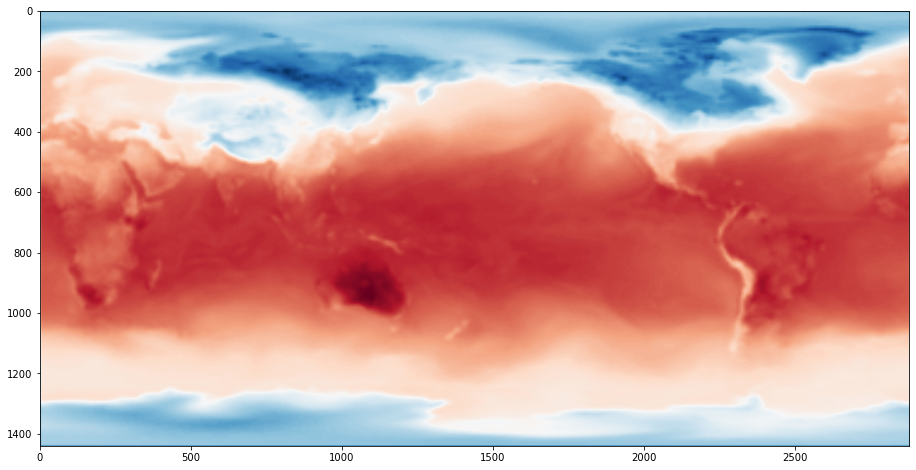

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
plt.imshow(dsets[0][::4, ::4], cmap='RdBu_r');

### Integración with `dask.array`

Haga una lista de objetos `dask.array` de su lista de objetos` h5py.Dataset` usando la función `da.from_array` con un tamaño de fragmento (chunk) de `(500, 500)`.

In [15]:
arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]
arrays

[dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 50

### Apile (Stack) esta lista de objetos `dask.array` es un solo objeto `dask.array` usando `da.stack`

Apílelos a lo largo del primer eje para que la forma de la matriz resultante sea "(31, 5760, 11520)".

In [16]:
x = da.stack(arrays, axis=0)
x

,Array,Chunk
Bytes,16.46 GB,2.00 MB
Shape,"(31, 5760, 11520)","(1, 500, 500)"
Count,17887 Tasks,8928 Chunks
Type,float64,numpy.ndarray


### Trace la media de esta matriz a lo largo del eje de tiempo (`0th`)

In [ ]:
# complete the following:
#fig = plt.figure(figsize=(16, 8))
#plt.imshow(..., cmap='RdBu_r')

In [17]:
result = x.mean(axis=0)
#fig = plt.figure(figsize=(16, 8))
#plt.imshow(result, cmap='RdBu_r');

In [18]:
result.shape

(5760, 11520)

In [19]:
result[:5,:5]

dask.array<getitem, shape=(5, 5), dtype=float64, chunksize=(5, 5), chunktype=numpy.ndarray>

In [21]:
y = result[:5,:5]
y.compute()

array([[25.50199644, 27.04757198, 28.59314752, 30.13872307, 31.68429861],
       [27.04757198, 28.68681877, 30.32606556, 31.96531234, 33.60455913],
       [28.59314752, 30.32606556, 32.05898359, 33.79190162, 35.52481965],
       [30.13872307, 31.96531234, 33.79190162, 35.6184909 , 37.44508017],
       [31.68429861, 33.60455913, 35.52481965, 37.44508017, 39.36534069]])

**Plot the difference of the first day from the mean**

In [ ]:
result = x[0] - x.mean(axis=0)
#fig = plt.figure(figsize=(16, 8))
#plt.imshow(result, cmap='RdBu_r');

### Ejercicio Submuestree y almacene

En el ejercicio anterior, el resultado de nuestro cálculo es pequeño, por lo que podemos llamar a `compute` de forma segura. A veces, nuestro resultado sigue siendo demasiado grande para caber en la memoria y queremos guardarlo en el disco. En estos casos, puede utilizar una de las dos funciones siguientes

1. `da.store`: almacena dask.array en cualquier objeto que admita la sintaxis de numpy setitem, p.

        f = h5py.File ('miarchivo.hdf5')
        salida = f.create_dataset (forma = ..., dtype = ...)
        
        da.store (my_dask_array, salida)
        
2. `da.to_hdf5`: Una función especializada que crea y almacena un objeto` dask.array` en un archivo `HDF5`.

        da.to_hdf5 ('datos/myfile.hdf5', '/salida', my_dask_array)
        
La tarea en este ejercicio es **usar un gran número de pasos para submuestrear el conjunto de datos completo por un factor de dos en la dirección de latitud y longitud y luego almacenar este resultado en el disco** usando una de las funciones enumeradas anteriormente.

Como recordatorio, el corte(slice) de Python toma tres elementos

    inicio: parada: paso

    >>> L = [1, 2, 3, 4, 5, 6, 7]
    >>> L [:: 3]
    [1, 4, 7]

In [ ]:
# ...

In [ ]:
import h5py
from glob import glob
import os
import dask.array as da

filenames = sorted(glob(os.path.join('data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]

arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]

x = da.stack(arrays, axis=0)

result = x[:, ::2, ::2]

da.to_zarr(result, os.path.join('data', 'myfile.zarr'), overwrite=True)

### Ejemplo: Lennard-Jones potential

El [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential) se utiliza en simulaciones particulares en física, química e ingeniería. Es altamente paralelizable.

Primero, ejecutaremos y perfilaremos la versión de Numpy en 7,000 partículas.

In [ ]:
import numpy as np

# make a random collection of particles
def make_cluster(natoms, radius=40, seed=1981):
    np.random.seed(seed)
    cluster = np.random.normal(0, radius, (natoms,3))-0.5
    return cluster

def lj(r2):
    sr6 = (1./r2)**3
    pot = 4.*(sr6*sr6 - sr6)
    return pot

# build the matrix of distances
def distances(cluster):
    diff = cluster[:, np.newaxis, :] - cluster[np.newaxis, :, :]
    mat = (diff*diff).sum(-1)
    return mat

# the lj function is evaluated over the upper traingle
# after removing distances near zero
def potential(cluster):
    d2 = distances(cluster)
    dtri = np.triu(d2)
    energy = lj(dtri[dtri > 1e-6]).sum()
    return energy

In [ ]:
cluster = make_cluster(int(7e3), radius=500)

In [ ]:
%time potential(cluster)

Tenga en cuenta que la función que consume más tiempo es `distancias`:

In [ ]:
# this would open in another browser tab
# %load_ext snakeviz
# %snakeviz potential(cluster)

# alternative simple version given text results in this tab
%prun -s tottime potential(cluster)

### Versión Dask 

Aquí está la versión de Dask. Solo la función "potencial" necesita ser reescrita para utilizar mejor Dask.

Tenga en cuenta que `da.nansum` se ha utilizado en toda la matriz de distancia $ NxN $ para mejorar la eficiencia en paralelo.

In [ ]:
import dask.array as da

# compute the potential on the entire
# matrix of distances and ignore division by zero
def potential_dask(cluster):
    d2 = distances(cluster)
    energy = da.nansum(lj(d2))/2.
    return energy

Convirtamos la matriz NumPy en una matriz Dask. Dado que toda la matriz NumPy cabe en la memoria, es más eficiente computacionalmente dividir la matriz por número de núcleos de CPU.

In [ ]:
from os import cpu_count

dcluster = da.from_array(cluster, chunks=cluster.shape[0]//cpu_count())

Convirtamos la matriz NumPy en una matriz Dask. Dado que toda la matriz NumPy cabe en la memoria, es más eficiente computacionalmente dividir la matriz por número de núcleos de CPU.

In [ ]:
e = potential_dask(dcluster)
%time e.compute()

Limitaciones
-----------

Dask Array no implementa toda la interfaz numpy. Usuarios que esperan esto
se sentirán decepcionados. En particular, Dask Array tiene las siguientes fallas:

1. Dask no implementa todo ``np.linalg`` Esto ha sido hecho por un
    número de excelentes implementaciones BLAS / LAPACK y es el foco de
    numerosos proyectos de investigación académica en curso.
2. Dask Array no admite algunas operaciones en las que la forma resultante
    depende de los valores de la matriz. Para los que sí apoya
    (por ejemplo, enmascarar un Dask Array con otra máscara booleana),
    los tamaños de los fragmentos serán desconocidos, lo que puede causar problemas con otros
    operaciones que necesitan conocer los tamaños de los fragmentos.
3. Dask Array no intenta operaciones como ``ordenar`` que son notoriamente
    difíciles de hacer en paralelo y tienen un valor algo disminuido en muy
    datos grandes (rara vez se necesita una clasificación completa).
    A menudo incluimos alternativas compatibles con el paralelo como ``topk``.
4. El desarrollo de Dask está impulsado por una necesidad inmediata, y 
    funciones muchos menos utilizados, como ``np.sometrue`` no se han implementado por pura
    pereza. Estos serían excelentes contribuciones a la comunidad.
    
* [Array documentation](https://docs.dask.org/en/latest/array.html)
* [Array screencast](https://youtu.be/9h_61hXCDuI)
* [Array API](https://docs.dask.org/en/latest/array-api.html)
* [Array examples](https://examples.dask.org/array.html)

In [23]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
